In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture


#random seed
np.random.seed(4324)

#### ładowanie danych już po feature engineeringu

In [40]:
#load different datasets
df1 = pd.read_csv('../Data/no_standarization.csv')
df2 = pd.read_csv('../Data/raw_normalized_scaled.csv')
df3 = pd.read_csv('../Data/log_normalized.csv')
df4 = pd.read_csv('../Data/log_scaled.csv')
df4_og = df4.copy()
df5 = pd.read_csv('../Data/removed_columns_no_standarization.csv')
df = pd.read_csv('../Data/our_data.csv')


In [5]:
df1.head()

,runtime_minutes,director_name,movie_averageRating,movie_numerOfVotes,approval_Index,production_year,month_sin,month_cos,number_of_professions,age,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,cluster
0,116.0,503.0,6.3,5077.0,3.823171,1996,1.000000e-10,1.000000e-10,3,2,...,0,0,0,0,0,0,0,0,0,2
1,114.0,299.0,6.2,22262.0,4.434679,1993,8.660254e-01,5.000000e-01,3,1,...,0,1,0,1,0,0,0,0,0,4
2,124.0,75.0,7.1,145614.0,6.078636,2011,1.000000e-10,1.000000e+00,3,1,...,0,0,0,0,0,0,0,0,0,4
3,125.0,350.0,7.0,110757.0,5.850243,1977,1.000000e-10,1.000000e-10,3,2,...,0,0,0,0,0,0,1,0,0,4
4,98.0,568.0,6.1,41748.0,4.643223,2000,5.000000e-01,8.660254e-01,2,2,...,0,0,0,0,0,0,0,0,0,2


### przypomnienie łokci

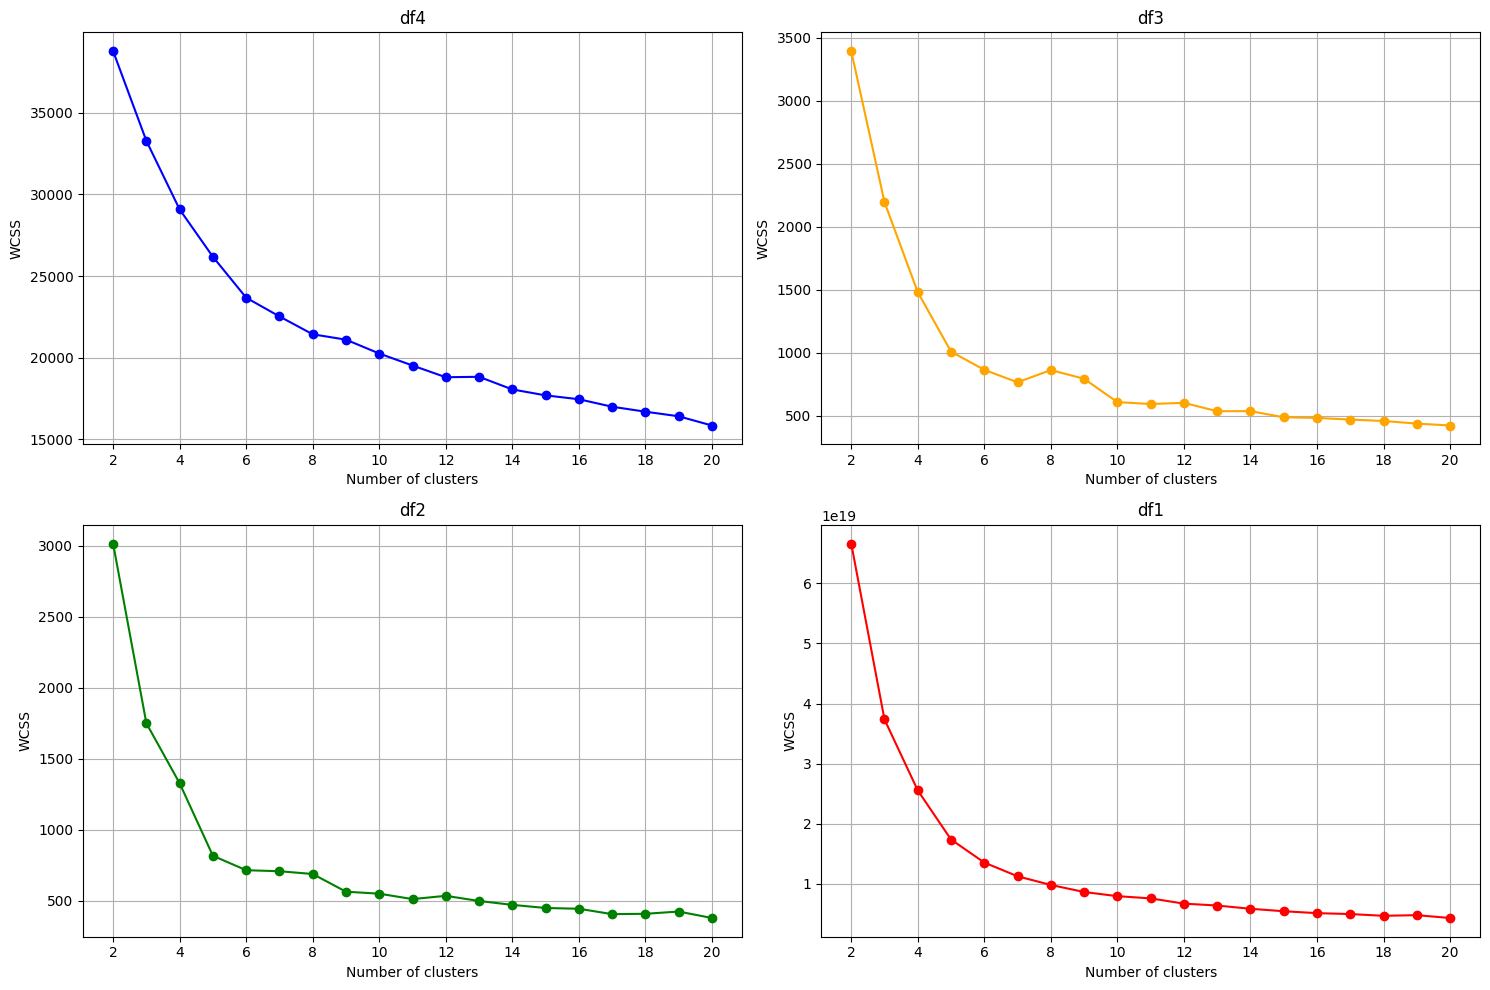

In [6]:

def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    return wcss

# Assuming v1, v2, v3, and v4 are your datasets
wcss_df4 = calculate_wcss(df4)
wcss_df3 = calculate_wcss(df3)
wcss_df2 = calculate_wcss(df2)
wcss_df1 = calculate_wcss(df1)


# Assuming wcss_v1, wcss_v2, wcss_v3, and wcss_v4 are defined lists
wcss_list = [wcss_df4, wcss_df3, wcss_df2, wcss_df1]
titles = ['df4', 'df3', 'df2', 'df1']
colors = ['b', 'orange', 'green', 'r']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, (wcss, title, color) in enumerate(zip(wcss_list, titles, colors)):
    row = i // 2
    col = i % 2
    axs[row, col].plot(range(2, 21), wcss, marker='o', color=color)
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Number of clusters')
    axs[row, col].set_ylabel('WCSS')
    axs[row, col].set_xticks(range(2, 22, 2))  # Set x-ticks every 2 units
    axs[row, col].grid()

plt.tight_layout()
plt.show()



optymalnie z łokcia myślę 7 klastrów, df4 lekko fika tam dla 7,ale dla reszty można uogólnić

### Modelowanie (na razie zrobione dla 7 klastrów (w metodach w których podaje się liczbe klastrów i tylko na ramce z nieprzeskalowanymi danymi, żeby sprawdzić analogicznie reszte wariantów opisałam na dole))

In [7]:
# wypróbuj różne metoday klasteryzacji dla N klastrów
def perform_clustering1(df4, N, df4_results,eps):
    # KMeans
    # how does KMeans work
    # 1. Randomly initialize the centroids
    # 2. Assign each data point to the closest centroid
    # 3. Recompute the centroids
    # 4. Repeat steps 2 and 3 until convergence

    kmeans = KMeans(n_clusters=N)
    kmeans.fit(df4)
    df4_results['kmeans'] = kmeans.labels_

    # AgglomerativeClustering
    # how does AgglomerativeClustering work
    # 1. Start with n clusters, each data point is a cluster
    # 2. Merge the two closest clusters
    # 3. Repeat step 2 until only a single cluster remains

    agglomerative = AgglomerativeClustering(n_clusters=N)
    agglomerative.fit(df4)
    df4_results['agglomerative'] = agglomerative.labels_

    # DBSCAN
    # how does DBSCAN work
    # 1. Randomly initialize a point
    # 2. Find all points within the eps distance from the point
    # 3. If there are more than min_samples points within eps distance, create a cluster
    # 4. Repeat steps 2 and 3 until all points are visited
    # find best eps and min_samples
    # eps - maximum distance between two samples for one to be considered as in the neighborhood of the other
    # min_samples - number of samples in a neighborhood for a point to be considered as a core point

    # function fo finding best eps and min_samples
    def find_best_eps_min_samples(data):
        from sklearn.neighbors import NearestNeighbors
        neigh = NearestNeighbors(n_neighbors=2)
        neigh.fit(data)
        distances, indices = neigh.kneighbors(data)
        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        plt.plot(distances)
        plt.axhline(y=2, color='r', linestyle='--')
        plt.title('Distances for DBSCAN')
        plt.show()

    find_best_eps_min_samples(df4)
    #what does the plot show
    # the plot shows the distances between each point and its closest neighbor
    # the point where the plot starts to grow rapidly is the best eps value


    dbscan = DBSCAN(eps=eps, min_samples=6) # dla innych danych trzeba zmienić eps i min_samples DB4 eps=2, min_samples=6, DB3 eps=0.3
    dbscan.fit(df4)
    df4_results['dbscan'] = dbscan.labels_

    # Birch
    # how is Birch different from KMeans
    # 1. Birch builds a tree structure to represent the data
    # 2. Birch does not require the number of clusters to be specified
    # 3. Birch does not require the data to be stored in memory
    # 4. Birch is faster than KMeans
    # ale generalnie Birch działa na podobnej zasadzie co KMeans

    birch = Birch(n_clusters=N)
    birch.fit(df4)
    df4_results['birch'] = birch.labels_

    # MiniBatchKMeans
    # how does MiniBatchKMeans work
    # MiniBatchKMeans uses mini-batches of data to update the centroids (other than that works like KMeans)

    mini_batch_kmeans = MiniBatchKMeans(n_clusters=N)
    mini_batch_kmeans.fit(df4)
    df4_results['mini_batch_kmeans'] = mini_batch_kmeans.labels_



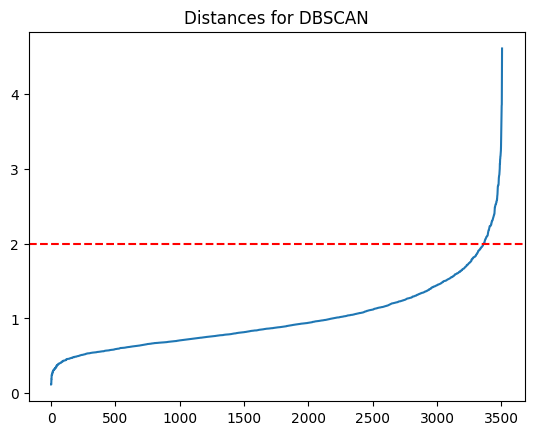

In [8]:
df4_results = pd.DataFrame()
perform_clustering1(df4, 7, df4_results,2)

z tego wykresu widać że najselnsowniej wybrać koło 2 pewnie jako eps, bo tam zaczyna rosnąć najbardziej

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
df4_tsne = tsne.fit_transform(df4)
df3_tsne = tsne.fit_transform(df3)
df2_tsne = tsne.fit_transform(df2)
df1_tsne = tsne.fit_transform(df1)
df5_tsne = tsne.fit_transform(df5)

# use standard scaler for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df4_s = scaler.fit_transform(df4)
df3_s = scaler.fit_transform(df3)
df2_s = scaler.fit_transform(df2)
df1_s = scaler.fit_transform(df1)
df5_s = scaler.fit_transform(df5)

pca = PCA(n_components=2)
df4_pca = pca.fit_transform(df4_s)
df3_pca = pca.fit_transform(df3_s)
df2_pca = pca.fit_transform(df2_s)
df1_pca = pca.fit_transform(df1_s)
df5_pca = pca.fit_transform(df5_s)


pca = PCA(n_components=3)
df4_pca2 = pca.fit_transform(df4_s)
df3_pca2 = pca.fit_transform(df3_s)
df2_pca2 = pca.fit_transform(df2_s)
df1_pca2 = pca.fit_transform(df1_s)
df5_pca2 = pca.fit_transform(df5_s)


In [10]:
def plot_clusters(df4, df4_pca, df4_pca2, df4_tsne): # Plotujemy 5 ostatnich kolumn
    # Plot the results using TSNE
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))

    for i, (col, ax) in enumerate(zip(df4.columns[-10:], axs.flatten())):
        ax.scatter(df4_tsne[:, 0], df4_tsne[:, 1], c=df4[col], cmap='tab10')
        ax.set_title(col)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot the results using PCA
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))

    for i, (col, ax) in enumerate(zip(df4.columns[-10:], axs.flatten())):
        ax.scatter(df4_pca[:, 0], df4_pca[:, 1], c=df4[col], cmap='tab10')
        ax.set_title(col)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot the results using PCA2 in 3d using plotly express
    import plotly.express as px
    import plotly.io as pio
    pio.renderers.default = 'browser'
    
    for i, col in enumerate(df4.columns[-10:]):
        fig = px.scatter_3d(x=df4_pca2[:, 0], y=df4_pca2[:, 1], z=df4_pca2[:, 2], color=df4[col])
        fig.show()


In [15]:
def perform_clustering2(df4, N, df4_results):
    # MeanShift
    # how does MeanShift work
    # 1. Randomly initialize the centroids
    # 2. Find the points within the bandwidth distance from the centroid
    # 3. Recompute the centroid as the mean of the points within the bandwidth distance
    # 4. Repeat steps 2 and 3 until convergence

    # what is bandwidth
    # bandwidth is the distance within which the points are considered to be close to each other
    # points outside the bandwidth distance are considered to be outliers

    # how is it different from KMeans
    # 1. MeanShift does not require the number of clusters to be specified
    # 2. MeanShift does not require the data to be stored in memory
    # 3. MeanShift is slower than KMeans

    mean_shift = MeanShift()
    mean_shift.fit(df4)
    df4_results['mean_shift'] = mean_shift.labels_

    # SpectralClustering
    # how does SpectralClustering work
    # 1. Construct a similarity matrix
    # 2. Compute the Laplacian matrix
    # 3. Compute the eigenvectors of the Laplacian matrix
    # 4. Use the eigenvectors to cluster the data

    spectral_clustering = SpectralClustering(n_clusters=N)
    spectral_clustering.fit(df4)
    df4_results['spectral_clustering'] = spectral_clustering.labels_

    # AffinityPropagation
    # how does AffinityPropagation work
    # 1. Compute the similarity matrix
    # 2. Compute the availability matrix
    # 3. Compute the responsibility matrix
    # 4. Compute the cluster centers
    # 5. Assign each data point to the closest cluster center

    affinity_propagation = AffinityPropagation()
    affinity_propagation.fit(df4)
    df4_results['affinity_propagation'] = affinity_propagation.labels_

    # OPTICS
    # how does OPTICS work
    # 1. Construct a reachability graph
    # 2. Compute the ordering of the points
    # 3. Extract the clusters from the ordering

    optics = OPTICS(min_samples=5)
    optics.fit(df4)
    df4_results['optics'] = optics.labels_

    # GaussianMixture
    # how does GaussianMixture work
    # 1. Initialize the parameters of the Gaussian distribution
    # 2. Compute the probability of each data point belonging to each cluster
    # 3. Update the parameters of the Gaussian distribution
    # 4. Repeat steps 2 and 3 until convergence
    
    gaussian_mixture = GaussianMixture(n_components=3)
    gaussian_mixture.fit(df4)
    df4_results['gaussian_mixture'] = gaussian_mixture.predict(df4)

In [16]:
perform_clustering2(df4, 7, df4_results)

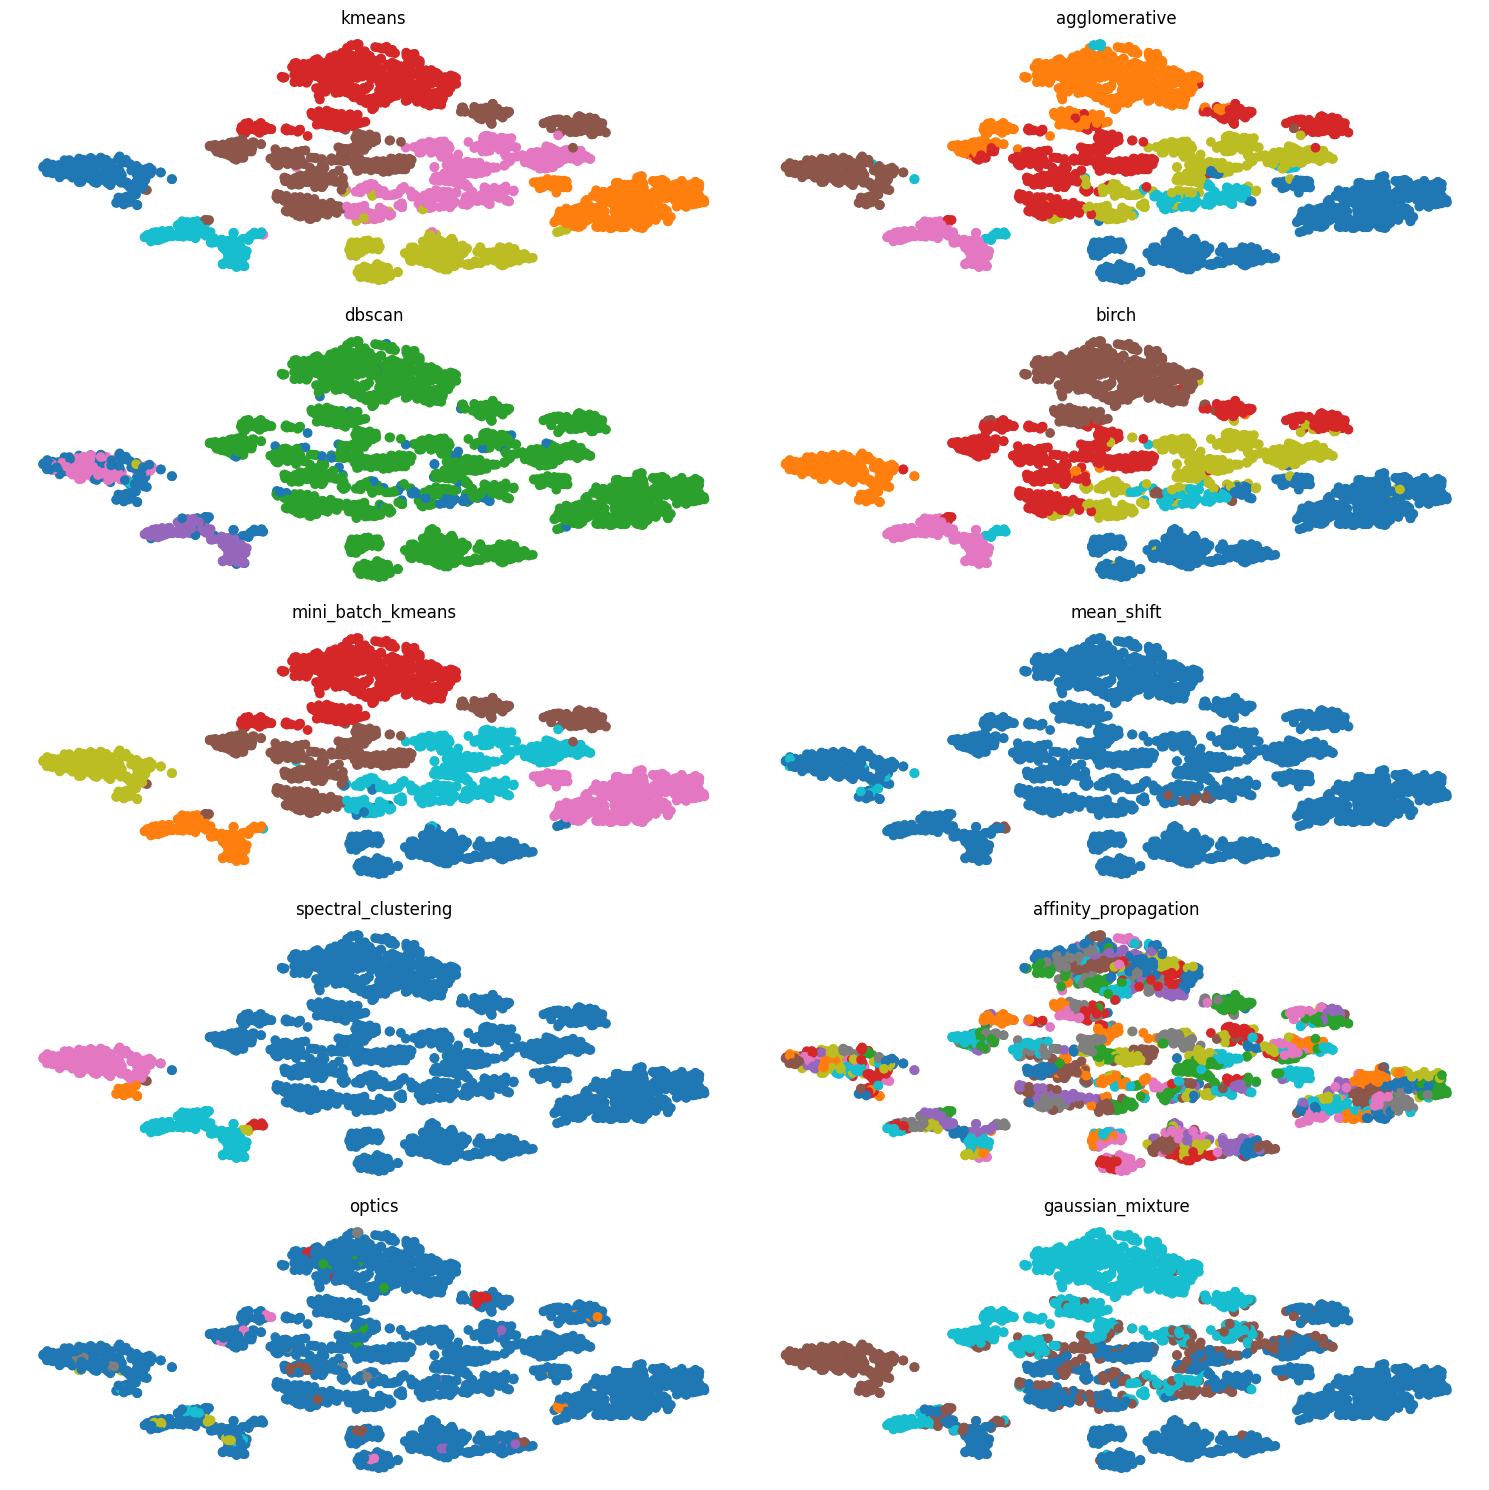

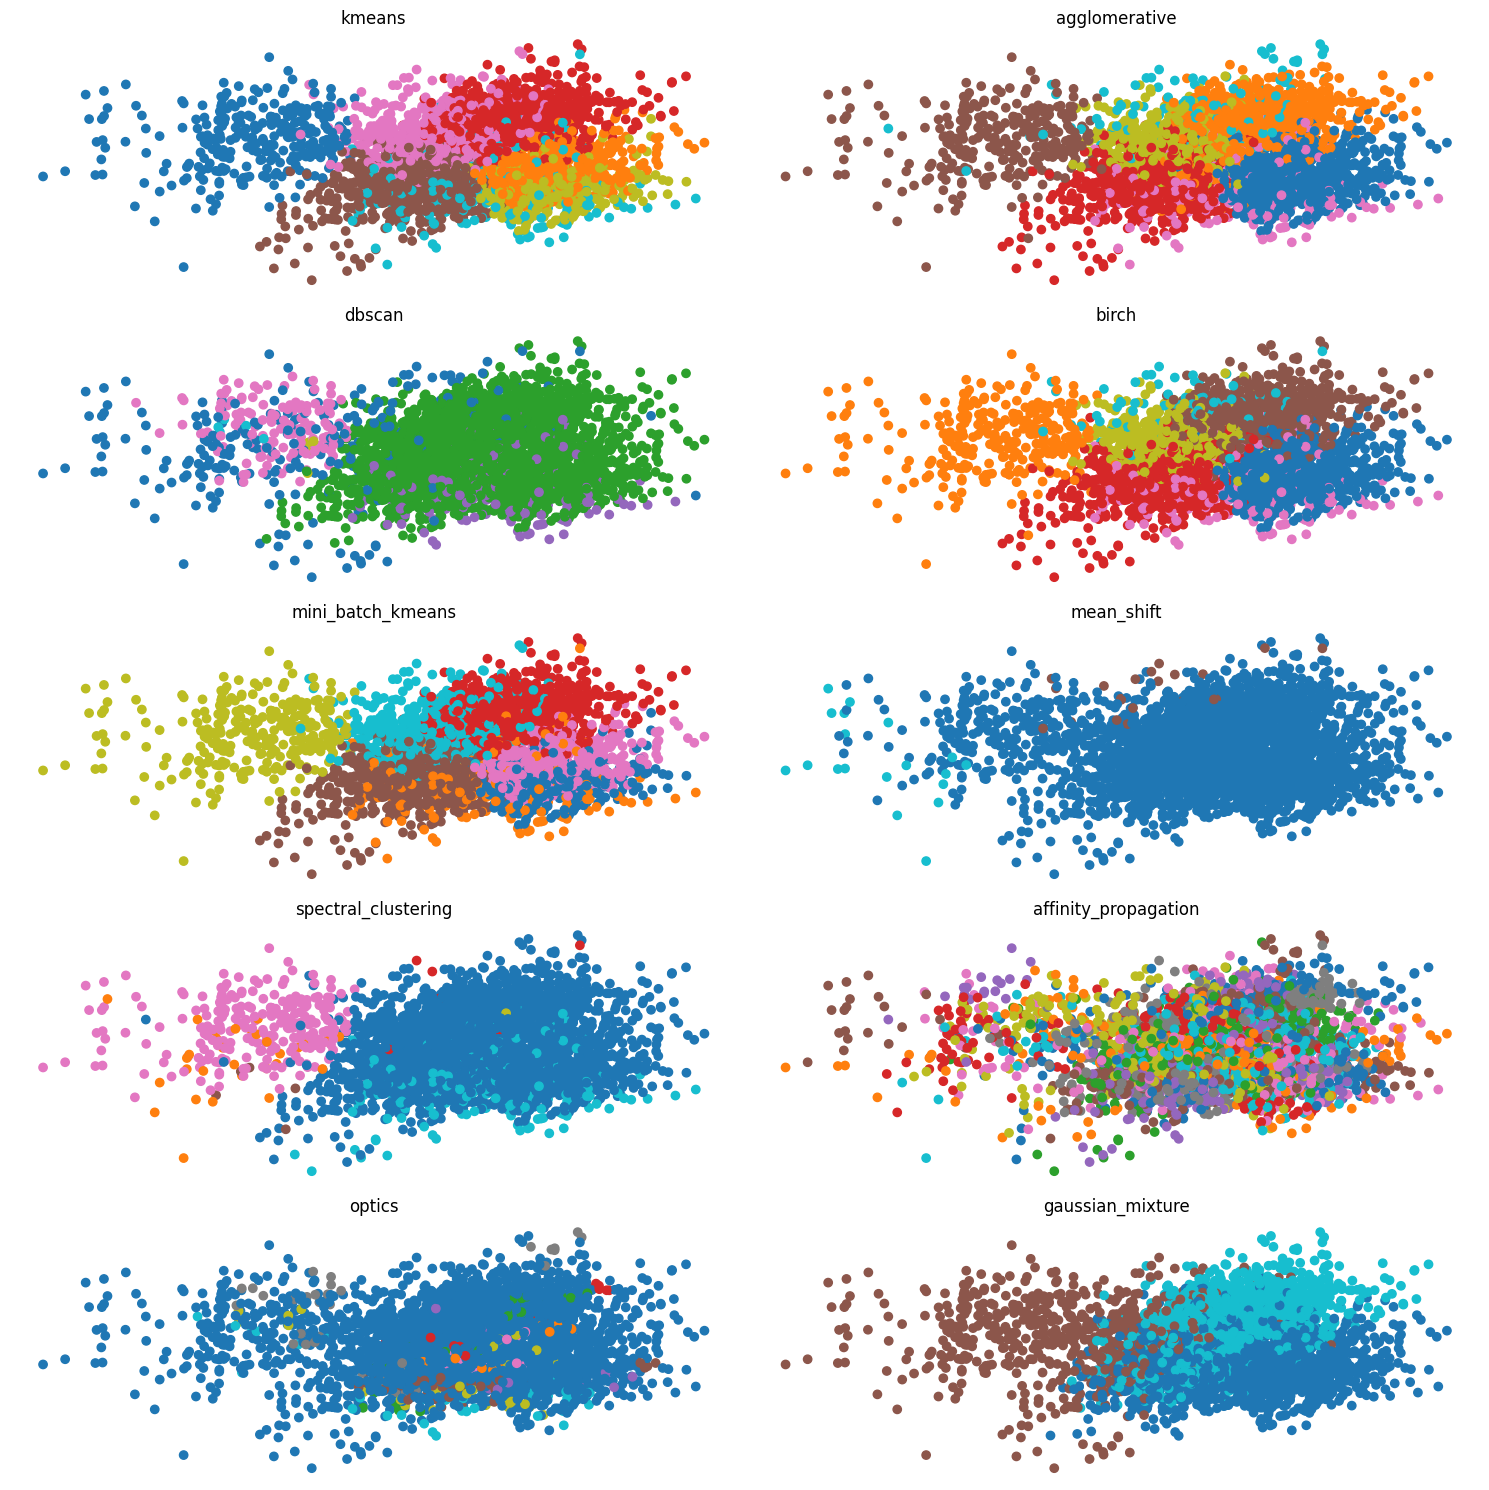

In [13]:
#plot_clusters(df4_results, df4_pca, df4_pca2, df4_tsne)

niżej ożna dodać jakies metryki jeszcze jak są

In [17]:
# create a table analysing the results using silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

def calculate_scores(df4_results):
    scores = pd.DataFrame(index=df4_results.columns, columns=['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
    for col in df4_results.columns:
        scores.loc[col, 'silhouette_score'] = silhouette_score(df4, df4_results[col])
        scores.loc[col, 'calinski_harabasz_score'] = calinski_harabasz_score(df4, df4_results[col])
        scores.loc[col, 'davies_bouldin_score'] = davies_bouldin_score(df4, df4_results[col])
        #scores.loc[col, 'adjusted_rand_score'] = adjusted_rand_score(df4['kmeans'], df4_results[col])
    return scores

In [18]:
df4_results

,kmeans,agglomerative,dbscan,birch,mini_batch_kmeans,mean_shift,spectral_clustering,affinity_propagation,optics,gaussian_mixture
0,4,5,0,5,6,0,0,20,-1,0
1,5,0,0,0,0,0,0,51,-1,0
2,2,1,0,3,2,0,0,89,-1,1
3,1,0,0,0,4,0,0,67,-1,2
4,2,1,0,2,2,0,0,16,-1,1
...,...,...,...,...,...,...,...,...,...,...
3501,4,5,0,5,6,0,0,144,-1,0
3502,5,0,0,0,0,0,0,62,-1,2
3503,2,1,0,3,2,0,0,77,-1,1
3504,1,0,0,0,4,0,0,39,-1,2


In [90]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [93]:


def calculate_best_model(scores):
    # Przeskalowanie kolumn
    epsilon = 1e-5

    # Przeskalowanie kolumny 'calinski_harabasz_score'
    scores['calinski_harabasz_score_scaled'] = scaler.fit_transform(scores[['calinski_harabasz_score']])
    scores['calinski_harabasz_score_scaled'] = scores['calinski_harabasz_score_scaled'] * (1 - 2 * epsilon) + epsilon

    # Przeskalowanie kolumny 'davies_bouldin_score'
    scores['davies_bouldin_score_scaled'] = scaler.fit_transform(scores[['davies_bouldin_score']])
    scores['davies_bouldin_score_scaled'] = scores['davies_bouldin_score_scaled'] * (1 - 2 * epsilon) + epsilon

    scores = scores[scores['silhouette_score'] > 0]

    #sil score
    max_silhouette_score = scores['silhouette_score'].max()
    scores['silhouette_score_scaled'] = scores['silhouette_score'] / max_silhouette_score
    scores.loc[scores['silhouette_score'] == max_silhouette_score, 'silhouette_score_scaled'] = 1

    #cal_score
    max_calinski_score = scores['calinski_harabasz_score_scaled'].max()
    scores['calinski_score_scaled'] = scores['calinski_harabasz_score_scaled'] / max_calinski_score
    scores.loc[scores['calinski_harabasz_score_scaled'] == max_calinski_score, 'calinski_score_scaled'] = 1  

    #davies score
    min_davies_score = scores['davies_bouldin_score_scaled'].min()
    scores['davies_score_scaled'] = 1 - min_davies_score / scores['davies_bouldin_score_scaled'] 
    scores.loc[scores['davies_bouldin_score_scaled'] == min_davies_score, 'davies_score_scaled'] = 1   

    #suma
    scores['suma'] = scores['silhouette_score_scaled'] + scores['calinski_score_scaled'] + scores['davies_score_scaled']


    # Indeks najlepszego algorytmu
    best_algorithm_index = scores['suma'].idxmax()
    return best_algorithm_index


In [19]:
scores = calculate_scores(df4_results)
print(scores)

                     silhouette_score calinski_harabasz_score  \
kmeans                       0.207956              660.188479   
agglomerative                0.219567              613.568485   
dbscan                       0.144495              202.329726   
birch                        0.219437              617.760437   
mini_batch_kmeans            0.207888              660.190823   
mean_shift                    0.33761                68.75433   
spectral_clustering          0.239462              206.933878   
affinity_propagation         0.135891              120.948563   
optics                      -0.458411                8.344191   
gaussian_mixture              0.16017              626.906127   

                     davies_bouldin_score  
kmeans                           1.563735  
agglomerative                    1.619636  
dbscan                           2.221054  
birch                            1.575808  
mini_batch_kmeans                1.563323  
mean_shift          

In [13]:
# plot the results
def plot_scores(scores):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))

    for i, (score, ax) in enumerate(zip(scores.columns, axs.flatten())):
        ax.bar(scores.index, scores[score])
        ax.set_title(score)
        ax.set_xticklabels(scores.index, rotation=45)
        ax.grid()
    plt.tight_layout()
    plt.show()

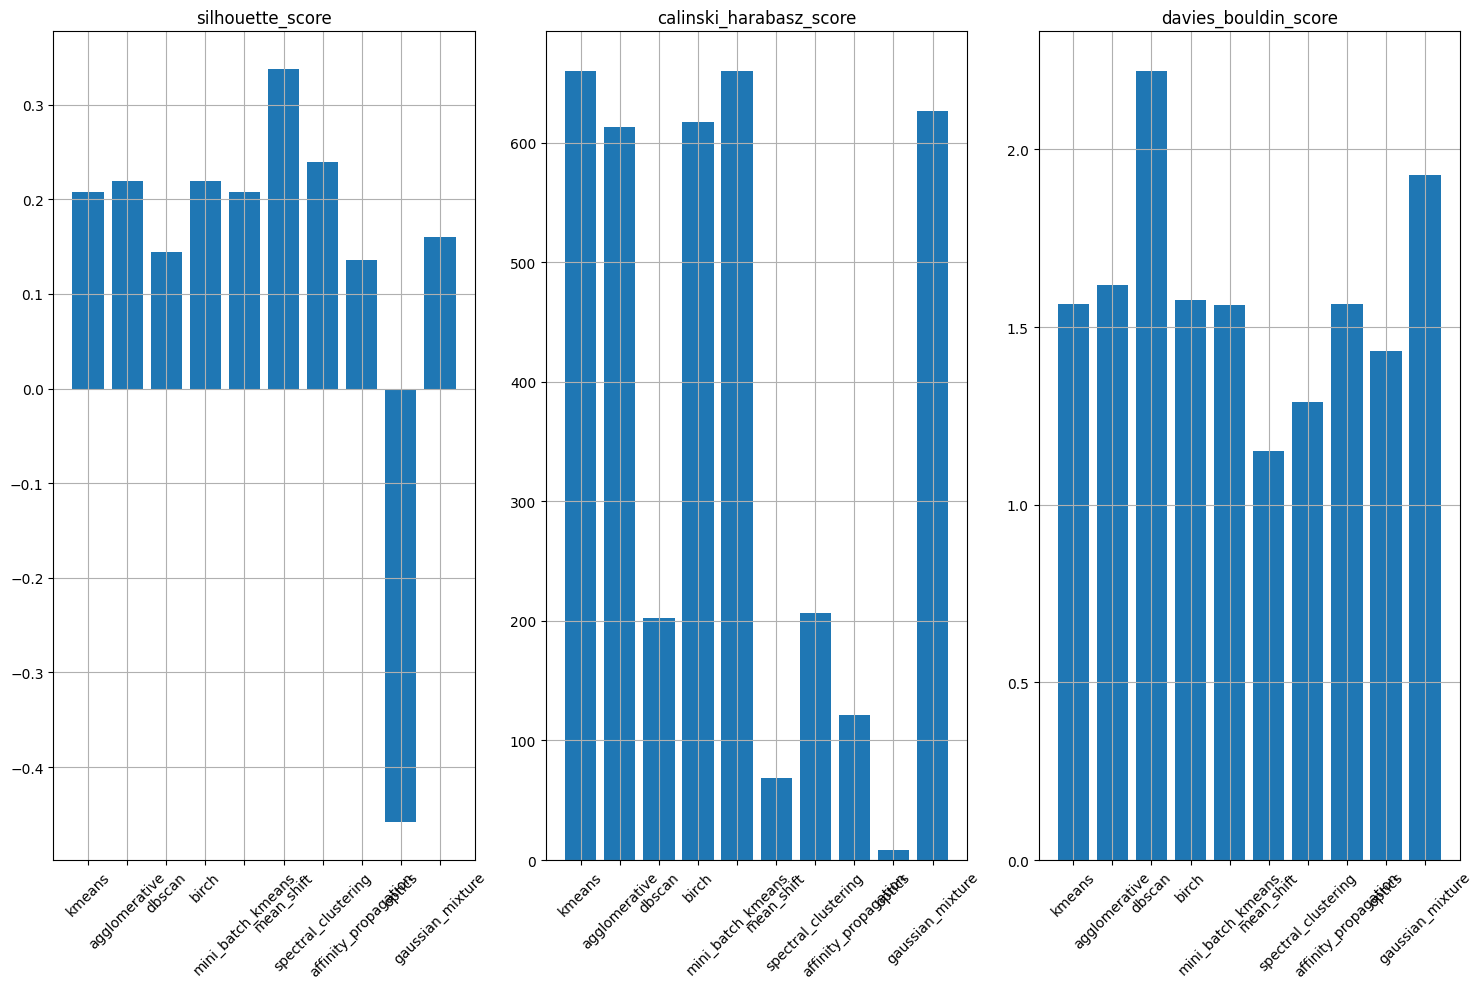

In [88]:
scores = calculate_scores(df4_results)
plot_scores(scores)

In [94]:
calculate_best_model(scores)

'kmeans'

jeśli zostawimy tyle modeli to może wypadałoby coś o nich się więcej dowiedzieć jak działają, komentarze do działania są przez copilot napisane, o metrykach sprawdzania też

tą funkcję z rekomendacją możaby chyba wrzucić, tak na koniec jako właśnie zastosowanie biznesowe żeby powtórzyć, używając już klasteringu tego najlepszego

dopisałabym funkcje która jakoś na podstawie tych indywidualnych scorów liczy który mode jest najlepszy (wziąć pod uwagę który score powinien być jak najmniejszy, który jak największy itd.)

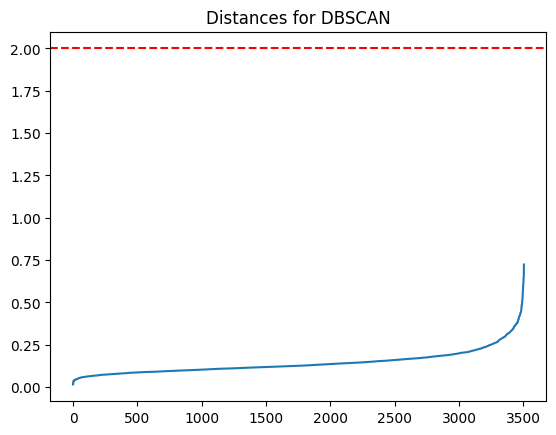

                     silhouette_score calinski_harabasz_score  \
kmeans                       0.104951              281.337925   
agglomerative                0.125866              292.677544   
dbscan                        0.01754              115.045653   
birch                        0.090319              220.538702   
mini_batch_kmeans            0.128506               331.08511   
mean_shift                   0.043258              235.095527   
spectral_clustering          0.136448              317.608029   
affinity_propagation         0.051756              143.831909   
optics                      -0.452902                8.270613   
gaussian_mixture             0.074444               327.81446   

                     davies_bouldin_score  
kmeans                           2.563486  
agglomerative                    2.443269  
dbscan                           3.158492  
birch                            2.499078  
mini_batch_kmeans                2.163642  
mean_shift          

In [37]:
#wyżej sprawdzone tylko dla df4, teraz dla df3
#uwaga trzeba recznie w dbscanie w perform_clustering1 zmienić eps na lepsze, bo inaczej nie działa dobrze, dla df3 np były dobry 0.30 na oko eps
df3_results = pd.DataFrame()
perform_clustering1(df3, 7, df3_results,0.3)
perform_clustering2(df3, 7, df3_results)
scores = calculate_scores(df3_results)
print(scores)

# plot the results
#plot_clusters(df3_results,df3_pca, df3_pca2, df3_tsne)

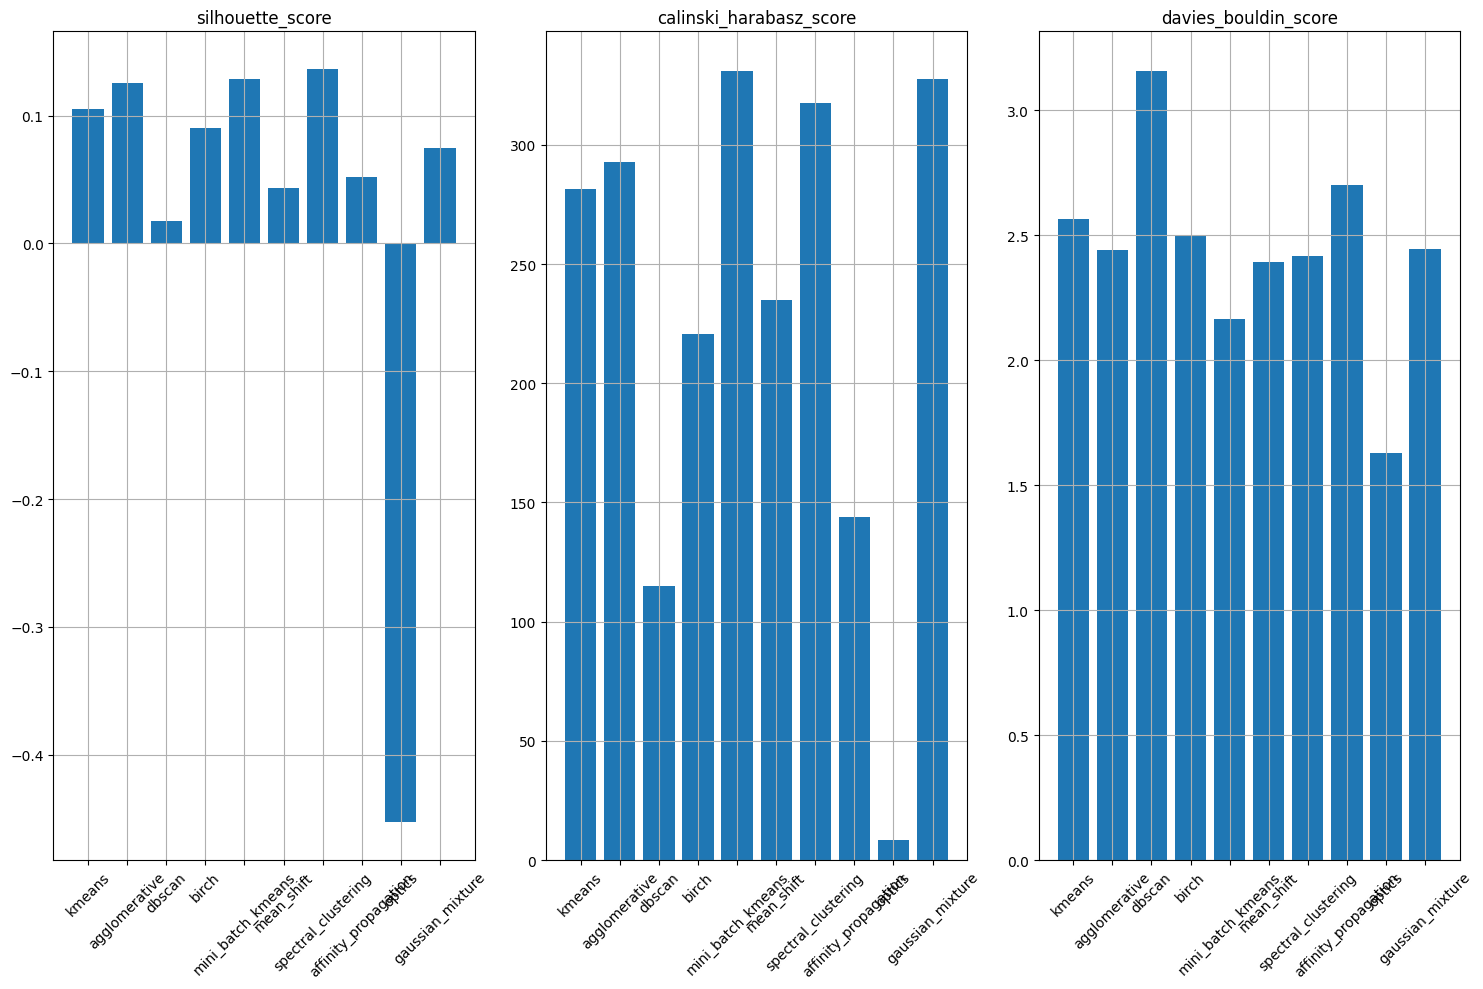

In [38]:
plot_scores(scores)

In [95]:
calculate_best_model(scores)

'kmeans'

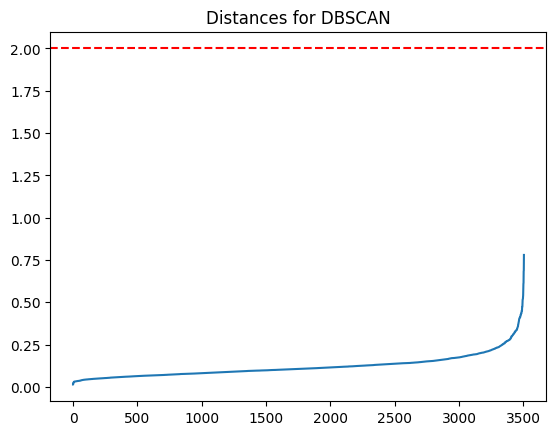

                     silhouette_score calinski_harabasz_score  \
kmeans                        0.06218              235.049354   
agglomerative                0.051247              251.031617   
dbscan                      -0.012845                 83.0462   
birch                        0.090936              209.124641   
mini_batch_kmeans            0.029016              227.366014   
mean_shift                   0.069846              235.373258   
spectral_clustering          0.058432              226.292711   
affinity_propagation        -0.028896               84.755187   
optics                      -0.439888                 7.18818   
gaussian_mixture             0.120886              332.155305   

                     davies_bouldin_score  
kmeans                           3.421113  
agglomerative                    2.637811  
dbscan                           3.390296  
birch                            2.612638  
mini_batch_kmeans                2.696755  
mean_shift          

In [73]:
df2_results = pd.DataFrame()
perform_clustering1(df2, 7, df2_results,0.3)
perform_clustering2(df2, 7, df2_results)
scores = calculate_scores(df2_results)
print(scores)

# plot the results
#plot_clusters(df3_results,df3_pca, df3_pca2, df3_tsne)

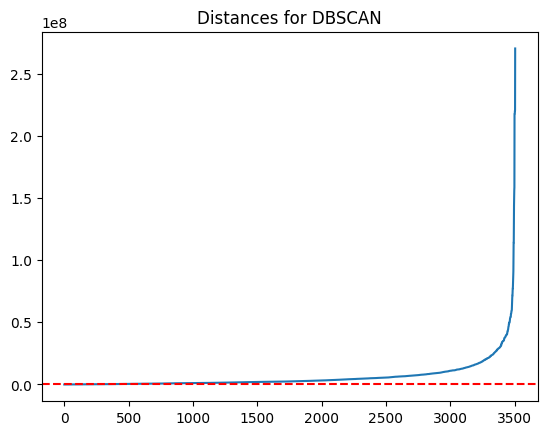

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [74]:
df1_results = pd.DataFrame()
perform_clustering1(df1, 7, df1_results,0.3)
perform_clustering2(df1, 7, df1_results)


In [79]:
df1_results.nunique()

kmeans                     7
agglomerative              7
dbscan                     1
birch                      7
mini_batch_kmeans          7
mean_shift                24
spectral_clustering        7
affinity_propagation    1146
optics                   156
gaussian_mixture           3
dtype: int64

In [80]:
df1_resultss = df1_results.drop('dbscan', axis=1)

In [83]:
scores = calculate_scores(df1_resultss)
print(scores)

                     silhouette_score calinski_harabasz_score  \
kmeans                       0.008282               99.139096   
agglomerative                -0.00061              135.286281   
birch                        -0.00061              135.286281   
mini_batch_kmeans           -0.005931              151.190814   
mean_shift                  -0.074582               11.992197   
spectral_clustering         -0.136072                1.130372   
affinity_propagation         -0.40394                2.658716   
optics                      -0.329042                4.957663   
gaussian_mixture            -0.010293               28.868815   

                     davies_bouldin_score  
kmeans                            5.47529  
agglomerative                     5.76373  
birch                             5.76373  
mini_batch_kmeans                6.647467  
mean_shift                       3.437411  
spectral_clustering             12.366216  
affinity_propagation             2.037583

warto by było dla różnej liczby klastrów też sprawdzić, znaczy niektóre metody same wybierają ile, ale do niektórych się podaje ile (jako argument w perform_clustering)

In [60]:
title = pd.read_csv('../Data/titles.csv')
df3 = df3.join(title)

In [62]:
df3.columns

Index(['runtime_minutes', 'director_name', 'movie_averageRating',
       'movie_numerOfVotes', 'approval_Index', 'production_year', 'month_sin',
       'month_cos', 'number_of_professions', 'Production budget $',
       'Domestic gross $', 'Worldwide gross $', 'cluster', 'Unnamed: 0',
       'movie_title'],
      dtype='object')

In [65]:
features = ['runtime_minutes', 'director_name', 'movie_averageRating',
       'movie_numerOfVotes', 'approval_Index', 'production_year', 'month_sin',
       'month_cos', 'number_of_professions', 'Production budget $',
       'Domestic gross $', 'Worldwide gross $']

In [108]:
import tkinter as tk
from tkinter import messagebox

def recommend_similar_movies(movie_title, n_recommendations=5):
    kmeans = KMeans(n_clusters=7, random_state=42)
    df3["cluster"] = kmeans.fit_predict(df3[features])
    movie_cluster = df3[df3["movie_title"] == movie_title]["cluster"].values[0]
    similar_movies = df3[(df3["cluster"] == movie_cluster) & (df3["movie_title"] != movie_title)]
    return similar_movies.sample(n=n_recommendations)['movie_title'].tolist()
def search_data(movie_list:list):
    info = []
    for movie in movie_list:
        matched = df[df['movie_title'] == movie]
        matched = matched[['movie_title', 'production_date', 'genres', 'runtime_minutes','director_name','movie_averageRating', 'movie_numerOfVotes',
       'approval_Index',]]
        if not matched.empty:
            inf = matched.iloc[0]
            formatted_info = "{} | Date: {} | Genres: {} | Runtime: {} | Director: {} | Rating: {} | Votes: {} | Approval: {}".format(
                inf['movie_title'], inf['production_date'], inf['genres'], inf['runtime_minutes'], inf['director_name'], 
                inf['movie_averageRating'], inf['movie_numerOfVotes'], inf['approval_Index'])
            info.append(formatted_info)
    return info
# Funkcja wyszukiwania filmów
def search_movies(event=None):
    search_text = entry.get().lower()
    matched_movies = df[df['movie_title'].str.lower().str.contains(search_text)]
    listbox.delete(0, tk.END)
    for title in matched_movies['movie_title']:
        listbox.insert(tk.END, title)
def on_select(event):
    selected_movie = listbox.get(listbox.curselection())
    searched = recommend_similar_movies(selected_movie)
    recommendations = '\n'.join(search_data(searched))  # Łączenie rekomendacji w jednym łańcuchu
    recommendations_var.set("Recommended movies:\n" + recommendations )
# Tworzenie głównego okna aplikacji
root = tk.Tk()

root.title("Movie Recommender")
#root.geometry("800x600")

# Tworzenie etykiety
label = tk.Label(root, text="Enter movie name:")
label.pack(pady=10)

# Tworzenie pola tekstowego
entry = tk.Entry(root, width=40)
entry.pack(pady=10)
entry.bind('<KeyRelease>', search_movies)

# Tworzenie listboxa do wyświetlania wyników wyszukiwania
listbox = tk.Listbox(root, width=50, height=10)
listbox.pack(pady=10)
listbox.bind('<<ListboxSelect>>', on_select)

# Tworzenie etykiety do wyświetlania rekomendacji
recommendations_var = tk.StringVar()
recommendations_label = tk.Label(root, textvariable=recommendations_var, justify=tk.LEFT, anchor="w", width=150)
recommendations_label.pack(pady=10)

# Uruchomienie głównej pętli Tkinter
root.mainloop()